In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helpers.dataloader import *
import pickle
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from inceptionResnet_v2 import *
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
torch.cuda.device_count()

1

In [3]:
root_dir = '/scratch/bva212/breastCancerData'
image_column = 'image file path'
batchSize =2
num_classes = 4
image_resize =1024

train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([image_resize,image_resize]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([image_resize,image_resize]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# randomTrainSet, randomValidationSet randomTestSet
train_data = CBISDDSMDataset('Train.pkl', root_dir, image_column, num_classes = num_classes, num_channel=3, transform = train_transform, transform_type = None, transform_prob=0.5)
val_data = CBISDDSMDataset('Val.pkl', root_dir, image_column, num_classes = num_classes, num_channel=3, transform = validation_transform, transform_type = None, transform_prob=0.5)
test_data = CBISDDSMDataset('Test.pkl', root_dir, image_column, num_classes = num_classes, num_channel=3, transform = validation_transform, transform_type = None, transform_prob=0.5)

image_datasets = {'train': train_data, 'val': val_data, 'test': test_data}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batchSize, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [4]:
inceptionNet = inceptionresnetv2(num_classes=1000, pretrained='imagenet')

In [5]:
inceptionNet.avgpool_1a = torch.nn.AdaptiveAvgPool2d(1)

In [6]:
fc_in_features = inceptionNet.last_linear.in_features
inceptionNet.last_linear = torch.nn.Linear(fc_in_features, num_classes)

In [7]:
inceptionNet.to(device)
inceptionNetParallel = torch.nn.DataParallel(inceptionNet)

In [8]:
PATH = '/scratch/bva212/dl4medProject/Inception_v2_4_Classes/InceptionResNet_v2_bestModelStateDict.pt'
inceptionNetParallel.load_state_dict(torch.load(PATH))

In [9]:
def evaluate_model(model, dataloader, loss_fn, phase = 'test'):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    outputs = np.array(0)
    preds = np.array(0)
    labels = np.array(0)
    for data in dataloader[phase]:
        inputs = data['x'].type(torch.FloatTensor).to(device)
        label = data['y'].to(device)
        output = model(inputs)
        loss = loss_fn(output, label)
        _, pred = torch.max(output, dim = 1)
        num_inputs = inputs.size()[0]
        output = F.softmax(output, dim = 1)
        outputs = np.append(outputs, output.cpu().detach().numpy())
        preds = np.append(preds, pred.cpu().detach().numpy())
        labels = np.append(labels, label.cpu().detach().numpy())
        running_correct += torch.sum(pred ==label).item()
        running_loss += loss.item()*num_inputs
        running_total += num_inputs
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)
    
    return outputs[1:], preds[1:], labels[1:], accuracy, loss

In [10]:
criterion = nn.CrossEntropyLoss()
outputs, preds, labels, accuracy, loss = evaluate_model(inceptionNetParallel, dataloaders, criterion)

In [11]:
print('Accuracy is: {}'.format(accuracy))
print('Loss is: {}'.format(loss))

Accuracy is: 0.6033333333333334
Loss is: 1.054938476284345


In [12]:
from sklearn.preprocessing import label_binarize

In [28]:
y_target = label_binarize(labels, classes= [0,1,2,3])
y_score = outputs.reshape(-1, 4)

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def get_AUC(y_score, y_target,plotROC=False):
    n_classes = y_score.shape[1]
    
    label_names = {0:'Benign Calcification',1:'Malignant Calcification',2:'Benign Mass',3:'Malignant Mass'}

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_target[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_target.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    if plotROC:
        lw = 2
        # Plot all ROC curves
        plt.figure(figsize = (8,6))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(label_names[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Inception ResNet v2 - 4 Class Classification Model')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc

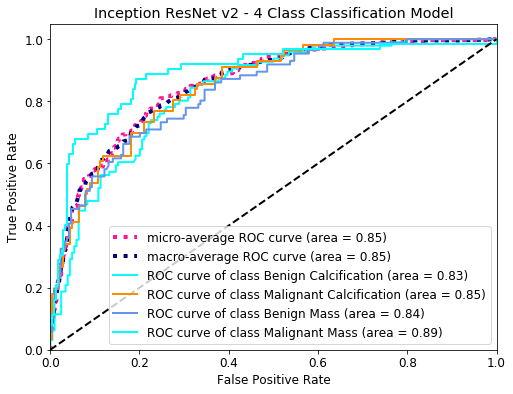

{0: 0.8314695669934641,
 1: 0.8492388758782201,
 2: 0.8350630297761357,
 3: 0.8910951477365139,
 'micro': 0.854111111111111,
 'macro': 0.8538314807866865}

In [65]:
get_AUC(y_score, y_target, True)

In [52]:
import itertools
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', 
                          root_dir = '/scratch/bva212/dl4medProject/', model_folder = '', 
                          cmap=None, normalize=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.legend()
    plt.show()

In [53]:
cm = confusion_matrix(labels, preds)

In [54]:
import matplotlib

In [59]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

In [63]:
plt.rcParams.update({'font.size': 12})
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

No handles with labels found to put in legend.


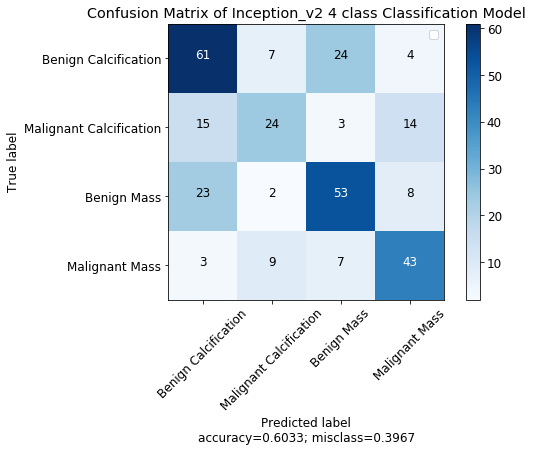

In [64]:
plot_confusion_matrix(cm, normalize = False, 
                      target_names = ['Benign Calcification', 'Malignant Calcification', 'Benign Mass', 'Malignant Mass'], 
                      title = "Confusion Matrix of Inception_v2 4 class Classification Model")

In [29]:
#from inception_resnetv2 import *
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
#from Dataloader_resize import *
 
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu') 
    
train_df_path = 'Train.pkl'
val_df_path = 'Val.pkl'
test_df_path = 'Test.pkl'
root_dir = '/scratch/bva212/breastCancerData'
image_column = 'image file path'
# transformed_dataset = {'train': CBISDDSMDataset(train_df_path,root_dir,image_column),
#                        'validate':CBISDDSMDataset(val_df_path,root_dir,image_column,transform_type='None'),
#                        'test':CBISDDSMDataset(test_df_path,root_dir,image_column,transform_type='None')}
 
transformed_dataset = {'train': CBISDDSMDataset(train_df_path,root_dir,image_column,num_channel=3,transform=train_transform,transform_type=None),
                       'validate':CBISDDSMDataset(val_df_path,root_dir,image_column,num_channel=3,transform=validation_transform,transform_type=None),
                       'test':CBISDDSMDataset(test_df_path,root_dir,image_column,num_channel=3,transform=validation_transform,transform_type=None)}
 
bs = 4
 
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}
 
model = inceptionresnetv2(num_classes=1000, pretrained='imagenet')
model.avgpool_1a = torch.nn.AdaptiveAvgPool2d(1)
fc_in_features = model.last_linear.in_features
model.last_linear = torch.nn.Linear(fc_in_features, 4)
model.to(device)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('/scratch/bva212/dl4medProject/Inception_v2_4_Classes/InceptionResNet_v2_bestModelStateDict.pt'))
 
label_all = np.zeros((1,4))
output_all = np.zeros((1,4))
# patient_num = []
# outputs = np.array(0)
# preds = np.array(0)
# labels = np.array(0)
running_correct = 0
running_total = 0
for data in dataloader['test']:
    model.eval()
    with torch.no_grad():
        image = torch.as_tensor(data['x'],dtype=torch.float,device=device)
        label = torch.as_tensor(data['y'],dtype=torch.long,device=device)
        output = model(image)
        _, preds = torch.max(output, dim = 1)
        output1 = torch.nn.functional.softmax(output,dim=1)
        num_imgs = image.size()[0]
        running_correct += torch.sum(preds ==label).item()
        running_total += num_imgs
        y_onehot = torch.zeros(label.shape[0], 4).scatter_(1, label.cpu().unsqueeze(1), 1)
        label_all = np.concatenate([label_all,y_onehot.numpy()],axis=0)
        output_all = np.concatenate([output_all,output1.cpu().detach().numpy()],axis=0)
#         patient_num.append(data['pid'])
 
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(label_all[1:, i], output_all[1:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_all.ravel(), output_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
 
from scipy import interp
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4
 
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
 
print(roc_auc)
acc = float(running_correct/running_total)
print(acc)

{0: 0.8314695669934641, 1: 0.8492388758782201, 2: 0.8350630297761357, 3: 0.8910951477365139, 'micro': 0.8547566371681417, 'macro': 0.8538314807866865}
0.6033333333333334
